# 04_SHAP (SHapley Additive exPlanations) - Kernel SHAP
### [shap](https://github.com/slundberg/shap): A game theoretic approach to explain the output of any machine learning model.

<img src="slide_image/shap_header.svg" width=720/>

In [1]:
!pip install imblearn shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.7 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Classification Problem

### Explore the dataset - Risk Factors for Cervical Cancer
#### Features
- Age: 年齡（歲）
- Number of sexual partners: 性伴侶數量
- First sexual intercourse: 首次性行為（歲）
- Num of pregnancies: 懷孕次數
- Smokes: 吸菸與否
- Smokes (years): 煙齡（年）
- Hormonal Contraceptive: 是否服用激素避孕藥
- Hormonal Contraceptives (years): 服用激素避孕藥的時間（年）
- IUD: 是否有宮內節育器
- IUD (years): 使用宮內節育器 (IUD) 的年數
- STDs: 是否患有性傳播疾病
- STDs (number): 患有幾個性傳播疾病
- STDs: Number of diagnosis: 性病診斷次數
- STDs: Time since first diagnosis: 第一次性病診斷後到現在的時間
- STDs: Time since last diagnosis: 上次性病診斷到現在的時間

#### Labels
- Biopsy: 健康與否

In [3]:
import pandas as pd
# Makes sure we see all columns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

class Cervical_DataLoader():
    def __init__(self):
        self.data = None

    def load_dataset(self, path="data/cervical.csv"):
        self.data = pd.read_csv(path)

    def preprocess_data(self):
        # 因為 STDs: Time since first diagnosis 和 STDs: Time since last diagnosis 缺少太多資料，因此刪除此兩列特徵
        self.data.drop(['STDs..Time.since.first.diagnosis','STDs..Time.since.last.diagnosis'], inplace=True, axis=1)

        # 將 lable mapping 到 0 和 1
        self.data['Biopsy'] = self.data['Biopsy'].map({'Healthy':0, 'Cancer':1})

        # 分別列出數值變數名稱和類別變數名稱
        num_cols = ['Age', 'Number.of.sexual.partners', 'First.sexual.intercourse', 'Num.of.pregnancies', 'Smokes..years.',
                    'Hormonal.Contraceptives..years.', 'IUD..years.','STDs..number.', 'STDs..Number.of.diagnosis']
        cat_cols = ['Smokes', 'Hormonal.Contraceptives', 'IUD', 'STDs']

        # 對類別變數進行 one hot encoding
        self.data = pd.get_dummies(data=self.data, columns=cat_cols)

    def get_data_split(self):
        y = self.data.pop('Biopsy')
        X = self.data.copy()
        return train_test_split(X, y, test_size=0.20, random_state=2022)

    def oversample(self, X_train, y_train):
        oversample = SMOTE(random_state=2022)
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = oversample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_over = pd.DataFrame(x_np, columns=X_train.columns)
        y_over = pd.Series(y_np, name=y_train.name)
        return x_over, y_over

    def undersample(self, X_train, y_train):
        undersample = ClusterCentroids(random_state=2022)
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = undersample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_under = pd.DataFrame(x_np, columns=X_train.columns)
        y_under = pd.Series(y_np, name=y_train.name)
        return x_under, y_under

In [5]:
# Load and preprocess data
data_loader = Cervical_DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()

# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)

(686, 17)
(172, 17)


In [6]:
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

After oversampling: (1286, 17)


### Classification Moldes
- Logistic Regression
- Decision Tree for Classification
- XGB for Classification

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#### Logistic Regression

In [8]:
# Fit logistic regression model
lr = LogisticRegression(random_state=2022, penalty='l1', solver='liblinear')
lr.fit(X_train.values, y_train.values)
print("Training finished.")

# Evaluate logistic regression model
y_pred = lr.predict(X_test.values)
print(f"F1 Score: {round(f1_score(y_test, y_pred, average='macro'), 2)}")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")

Training finished.
F1 Score: 0.48
Accuracy: 0.7


###  Kernel SHAP to explain Logistic Regression

In [9]:
import shap
shap.initjs()

In [10]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model=lr.predict_proba, data=X_train)
shap_values = explainer.shap_values(X=X_test, nsamples=100)

  0%|          | 0/172 [00:00<?, ?it/s]

In [16]:
# shape = (測試資料筆數, 特徵數, 標籤類別數)
print(f'shape of SHAP values: {shap_values.shape}')

shape of SHAP values: (172, 17, 2)


#### Global interpretability
- 點的顏色: Feature value 的大小，越紅越大、越藍越小
- X 軸: 該點對於 shap value 的影響，也就是對預測值的影響。
- Y 軸: 各個 features

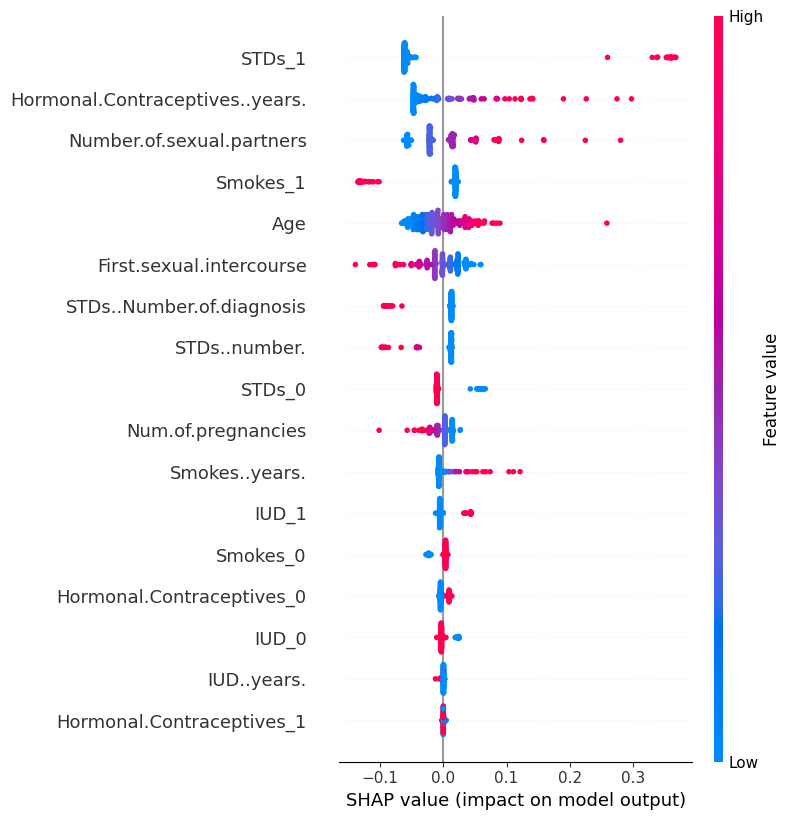

In [17]:
# 看類別1(Cancer)的shape values
shap.summary_plot(shap_values[:, :, 1], X_test)

#### Local interpretability

Explain a single prediction from the test set

In [24]:
shap.initjs()
# plot the SHAP values for output of the first instance
print(f'Prediction for 1st sample in X_test: {lr.predict_proba(X_test.iloc[[0], :].values)[0]}')
# 第一類標籤預測概率的期望值
print("base value =", explainer.expected_value[1])
shap.force_plot(explainer.expected_value[1], shap_values[0, :,1], X_test.iloc[0,:])

Prediction for 1st sample in X_test: [0.50367906 0.49632094]
base value = 0.4999999879463946
